In [ ]:
# Start using python os.walk to read ./train filenames
import os
for root, dirs, files in os.walk("./train"):
    print(f'{len(files)} files in total.')
    for file in files[:3]:
        print(os.path.join(root, file).replace("\\", "/"))

21765 files in total.
./train/00000.jpg
./train/00001.jpg
./train/00002.jpg


Image shape (128, 128, 3)


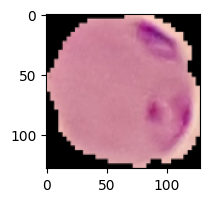

In [ ]:
# Use matplotlib.pyplot to read and display ./train/filename.jpg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
f = './train/09881.jpg'
img = mpimg.imread(f)
print('Image shape', img.shape)
plt.figure(figsize = (2, 2))
plt.imshow(img)
plt.show()

In [ ]:
# Read the infected status for each ./train/filename.jpg from ./train_labels.csv
# Rewrite to map filename.jpg to ./train_labels.csv
# Find the corresponding infected value
import pandas as pd
df = pd.read_csv('./train_labels.csv')
print(df.shape)
df[:4]

(21765, 2)


,filename,infected
0,00000.jpg,1
1,00001.jpg,1
2,00002.jpg,1
3,00003.jpg,0


In [ ]:
# Retrieve the corresponding infected value by file name
import re
print(re.split(r"/|\\", f)[-1])
df[ df['filename']==re.split(r"/|\\", f)[-1] ].infected.values[0]

09881.jpg


1

In [ ]:
# All in one
import pandas as pd
df = pd.read_csv('./train_labels.csv')

import os
for root, dirs, files in os.walk("./train"):
    print(root.replace("\\", "/"))
    print(dirs)
    print(files[:4], "\n")
    for file in files[:10]:
        print(os.path.join(root, file).replace("\\", "/"), \
              df[ df['filename']==re.split(r"/|\\", os.path.join(root, file))[-1] ].infected.values[0])

./train
[]
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg'] 

./train/00000.jpg 1
./train/00001.jpg 1
./train/00002.jpg 1
./train/00003.jpg 0
./train/00004.jpg 0
./train/00005.jpg 1
./train/00006.jpg 0
./train/00007.jpg 1
./train/00008.jpg 1
./train/00009.jpg 0


In [ ]:
# Prepare X = all image data, expected shape = (21765, 128, 128, 3)
# Prepare y = df.inftected, expected shape = (21765, 1)
# All in one II
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
df = pd.read_csv('./train_labels.csv')
images = [] # Put image data in
target = [] # Put the corresponding df.inftected value
for root, dirs, files in os.walk("./train"):
    for file in files[:10]:
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

        print(os.path.join(root, file).replace("\\", "/"), label)

X, y = np.array(images), np.array(target)
print(X.shape, y.shape)
print(f"\n{X[0].min()}, {X[0].max()}")

./train/00000.jpg 1
./train/00001.jpg 1
./train/00002.jpg 1
./train/00003.jpg 0
./train/00004.jpg 0
./train/00005.jpg 1
./train/00006.jpg 0
./train/00007.jpg 1
./train/00008.jpg 1
./train/00009.jpg 0
(10, 128, 128, 3) (10,)

0.0, 1.0


In [ ]:
import numpy as np
from tqdm import tqdm

images = [] # Put image data in
target = [] # Put the corresponding df.inftected value
for root, dirs, files in os.walk("./train"):
    for file in tqdm(files[:-1]):
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

X, y = np.array(images), np.array(target)
print(X.shape, y.shape)

100%|██████████| 21764/21764 [00:32<00:00, 673.36it/s]


(21764, 128, 128, 3) (21764,)


In [ ]:
# Check whether class samples are imbalanced
#     sum(y)/len(y) # proportion of 1 (infected)
# 1 - sum(y)/len(y) # proportion of 0 (healthy)
sum(y)/len(y), 1 - sum(y)/len(y) # (0.495, 0.504) # 1:1.018

(0.4951755192060283, 0.5048244807939717)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2018081517)

X_train[0].min(), X_train[0].max()

(0.0, 1.0)

In [ ]:
# Double-check
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15234, 128, 128, 3), (6530, 128, 128, 3), (15234,), (6530,))

In [ ]:
# Use a Keras sequential model for binary classification on X and y
# Where X shape is (21764, 128, 128, 3) and y shape is (21764,)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # ≡ tf.keras.Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, SGD

# Build model
pen = .0000005 # kernel regularizer penalty
ratio_SE = 2
ratio_CBAM = 2
kernel_size = 7
# input_shape = X_train.shape[1:] # (15234, 128, 128, 3) -> (128, 128, 3)
model = Sequential([
	# keras.Input(shape=input_shape),
	# 1st convolution
	Conv2D(16, 3, activation='relu', input_shape=(128, 128, 3), kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 2nd convolution
	Conv2D(16, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 3rd convolution
	Conv2D(32, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 4th convolution
	Conv2D(32, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 5th convolution
	Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 6th convolution
	# Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	# MaxPooling2D((2, 2)),
	# 7th convolution
	# Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	# MaxPooling2D((2, 2)),
	# Flatten layer
	GlobalAveragePooling2D(),
	Dropout(.5),
	BatchNormalization(),
	# Fully connected layer
	Dense(64, activation='relu', kernel_initializer='normal'),
	Dropout(.5),
	BatchNormalization(),
	# Dense(64, activation='relu', kernel_initializer='normal'),
	# Dropout(.5),
	# BatchNormalization(),
	# Output layer (binary classification)
	Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=.0001)
# optimizer = Adam(learning_rate=.00013, beta_1=.8, beta_2=.99, amsgrad=False)
result = model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=1000, restore_best_weights=True)
callbacks = [early_stopping]
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# callbacks = [early_stopping, ReduceLROnPlateau(patience=3, factor=.8, min_lr=1e-7)]

keras.backend.clear_session() # reset global state generated by TF-Keras / release VRAM
import gc; gc.collect()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

##### <b>The following training is performed without <i style="color: #FF0; background: #000;">Data Augmentation</i>.<br/>If you want to apply <i style="color: #FF0; background: #000;">Data Augmentation</i> before training, skip this section and jump directly to the later <i style="color: #FF0; background: #000;">Data Augmentation</i> section, then start training.</b>

In [ ]:
# Train the model
epochs = 30
train_history = model.fit(X_train, y_train, validation_split=.2, epochs=epochs, batch_size=32,
							verbose=2, callbacks=callbacks)
print("Done！")

Epoch 1/30
381/381 - 7s - loss: 0.7048 - accuracy: 0.5371 - val_loss: 0.6920 - val_accuracy: 0.5087 - 7s/epoch - 18ms/step
Epoch 2/30
381/381 - 3s - loss: 0.6607 - accuracy: 0.6034 - val_loss: 0.6445 - val_accuracy: 0.6344 - 3s/epoch - 9ms/step
Epoch 3/30
381/381 - 3s - loss: 0.6097 - accuracy: 0.6749 - val_loss: 0.5320 - val_accuracy: 0.7804 - 3s/epoch - 9ms/step
Epoch 4/30
381/381 - 3s - loss: 0.3872 - accuracy: 0.8508 - val_loss: 0.2002 - val_accuracy: 0.9314 - 3s/epoch - 9ms/step
Epoch 5/30
381/381 - 3s - loss: 0.2242 - accuracy: 0.9292 - val_loss: 0.1788 - val_accuracy: 0.9334 - 3s/epoch - 9ms/step
Epoch 6/30
381/381 - 3s - loss: 0.2016 - accuracy: 0.9413 - val_loss: 0.1904 - val_accuracy: 0.9399 - 3s/epoch - 9ms/step
Epoch 7/30
381/381 - 3s - loss: 0.1965 - accuracy: 0.9408 - val_loss: 0.1627 - val_accuracy: 0.9485 - 3s/epoch - 8ms/step
Epoch 8/30
381/381 - 3s - loss: 0.1918 - accuracy: 0.9440 - val_loss: 0.1681 - val_accuracy: 0.9475 - 3s/epoch - 8ms/step
Epoch 9/30
381/381 - 3s

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy of testing data = {accuracy:.2%}")
print(f"Loss of testing data = {loss:.2%}")
model.save("./model_CNN_myADJ.keras")

205/205 [==============================] - 1s 5ms/step - loss: 0.1155 - accuracy: 0.9617
Accuracy of testing data = 96.17%
Loss of testing data = 11.55%


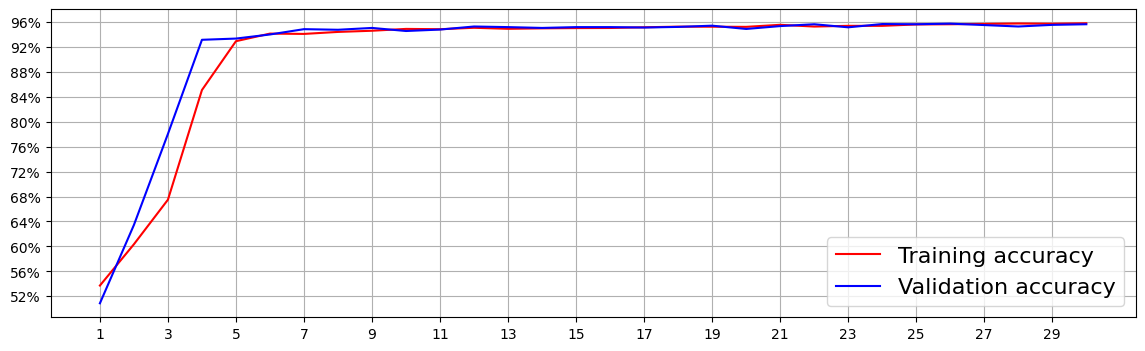

In [ ]:
# accuracy chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
x = np.arange(0, epochs, 2)
plt.xticks(ticks=x, labels=x+1)
y = np.arange(0, 1.05, .04)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(train_history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

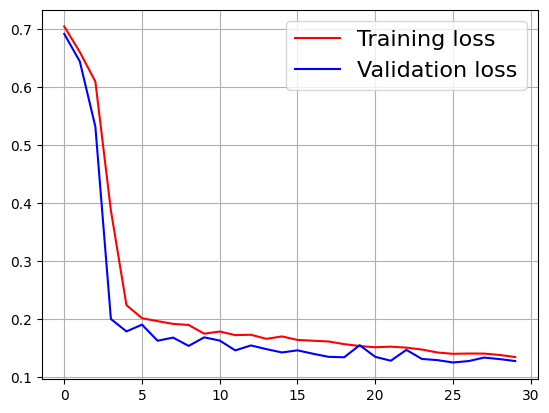

In [ ]:
# loss chart
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# y = np.arange(0, 1.05, .05)
# plt.yticks(ticks=y)
plt.plot(train_history.history['loss'], 'r', label='Training loss')
plt.plot(train_history.history['val_loss'], 'b', label='Validation loss')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

./train/00002.jpg [1] <--- Real State


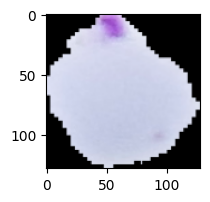

1/1 [==============================] - 0s 123ms/step
[0.96618927]
1/1 [==============================] - 0s 16ms/step
['Inflected']


In [ ]:
# All in one Final prediction
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random
df = pd.read_csv('./train_labels.csv')
images = [] # Put image data in
target = [] # Put the corresponding df.inftected value
for root, dirs, files in os.walk("./train"):
    files = files[-1:] + files[:5]
    for file in [ random.choice(files) ]:
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

X_predict, y_fact = np.array(images), np.array(target)
print(os.path.join(root, file).replace("\\", "/"), y_fact, "<--- Real State")
plt.figure(figsize = (2, 2))
plt.imshow(X_predict[0].reshape(128, 128, 3))
plt.show()
print(model.predict(X_predict)[0])
print( np.where(model.predict(X_predict)[0] > 0.5, 'Inflected', 'Uninfected') )

In [26]:
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=10,          # Random rotation angle (in degrees)
    width_shift_range=.1,       # Random horizontal shift (as a fraction of image width)
    height_shift_range=.1,      # Random vertical shift (as a fraction of image height)
    horizontal_flip=True,       # Random horizontal flip
    vertical_flip=True,         # Random vertical flip
    shear_range=10,             # Random shear angle (in degrees)
    zoom_range=.2,              # Random zoom range (fractional scale factor)
    preprocessing_function=None,
    # channel_shift_range=.1,    # Random channel shift (hue/saturation variation)
    fill_mode="constant", cval=0  # Border pixel filling: when a transform creates empty pixels,
                                  # fill them with the constant value 0 instead of the default "nearest"
)
gen_val = ImageDataGenerator()
X_val, X_test2, y_val, y_test2 = train_test_split(X_test, y_test, test_size=.33, stratify=y_test, random_state=2034581517)
train_batches = gen.flow(X_train, y_train, batch_size=32, seed=2034581517)
val_batches = gen_val.flow(X_val, y_val, batch_size=32, seed=2034581517)
test_batches = gen_val.flow(X_test2, y_test2, batch_size=32, seed=2034581517)

In [ ]:
epochs = 200
model = keras.models.load_model('./model_CNN_myADJ.keras')

# optimizer = Adam(learning_rate=.00013, beta_1=.999, beta_2=.99999, amsgrad=False, decay=.008, clipnorm=20.)
optimizer = Adam(learning_rate=.00013, beta_1=.7, beta_2=.98, amsgrad=False)
result = model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3000, restore_best_weights=True)
callbacks = [early_stopping]
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=.8, min_lr=1e-7)
# callbacks = [early_stopping, reduce_lr]

keras.backend.clear_session() # reset global state generated by TF-Keras / release VRAM
import gc; gc.collect()
train_history = model.fit(train_batches,
                          steps_per_epoch = len(X_train) // 32 + 1,
                          epochs = epochs,
                          validation_data = val_batches,
                        #   validation_data = (X_val, y_val),
                          validation_steps = len(X_val) // 32 + 1,
                          verbose = 2, callbacks = callbacks)
print("Done！")

Epoch 1/200
477/477 - 26s - loss: 0.1991 - accuracy: 0.9374 - val_loss: 0.1299 - val_accuracy: 0.9563 - 26s/epoch - 55ms/step
Epoch 2/200
477/477 - 23s - loss: 0.1882 - accuracy: 0.9412 - val_loss: 0.1272 - val_accuracy: 0.9584 - 23s/epoch - 48ms/step
Epoch 3/200
477/477 - 23s - loss: 0.1883 - accuracy: 0.9409 - val_loss: 0.1771 - val_accuracy: 0.9559 - 23s/epoch - 48ms/step
Epoch 4/200
477/477 - 24s - loss: 0.1874 - accuracy: 0.9395 - val_loss: 0.1689 - val_accuracy: 0.9547 - 24s/epoch - 50ms/step
Epoch 5/200
477/477 - 23s - loss: 0.1846 - accuracy: 0.9427 - val_loss: 0.1276 - val_accuracy: 0.9563 - 23s/epoch - 49ms/step
Epoch 6/200
477/477 - 25s - loss: 0.1767 - accuracy: 0.9438 - val_loss: 0.1290 - val_accuracy: 0.9554 - 25s/epoch - 53ms/step
Epoch 7/200
477/477 - 24s - loss: 0.1779 - accuracy: 0.9458 - val_loss: 0.1466 - val_accuracy: 0.9591 - 24s/epoch - 50ms/step
Epoch 8/200
477/477 - 24s - loss: 0.1798 - accuracy: 0.9433 - val_loss: 0.1232 - val_accuracy: 0.9561 - 24s/epoch - 51

In [28]:
# Evaluate the model
# loss, accuracy = model.evaluate(X_test2, y_test2)
loss, accuracy = model.evaluate(test_batches, steps = len(X_test2)//32 + 1)
print(f"Accuracy of testing data = {accuracy:.2%}")
print(f"Loss of testing data = {loss:.2%}")
model.save("./model_CNN_myADJ_DataAugmt.keras")

68/68 [==============================] - 0s 7ms/step - loss: 0.0880 - accuracy: 0.9759
Accuracy of testing data = 97.59%
Loss of testing data = 8.80%


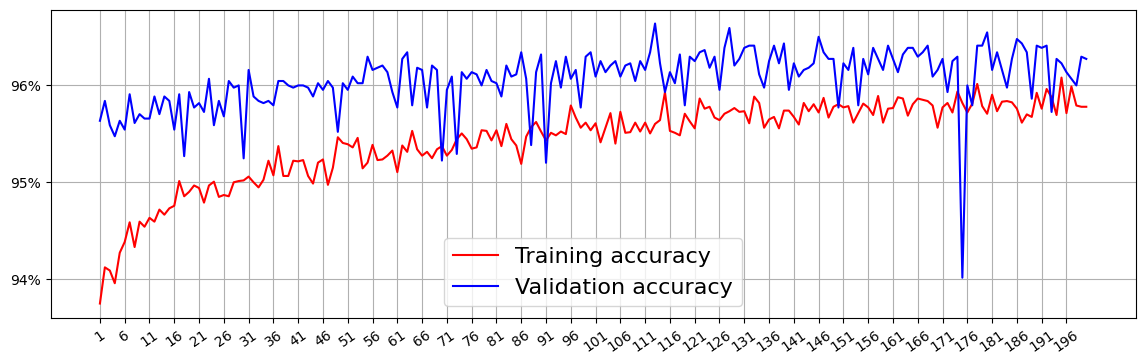

In [31]:
# accuracy chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
x = np.arange(0, epochs, 5)
plt.xticks(ticks=x, labels=x+1, rotation=35)
y = np.arange(0, 1.05, .01)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(train_history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

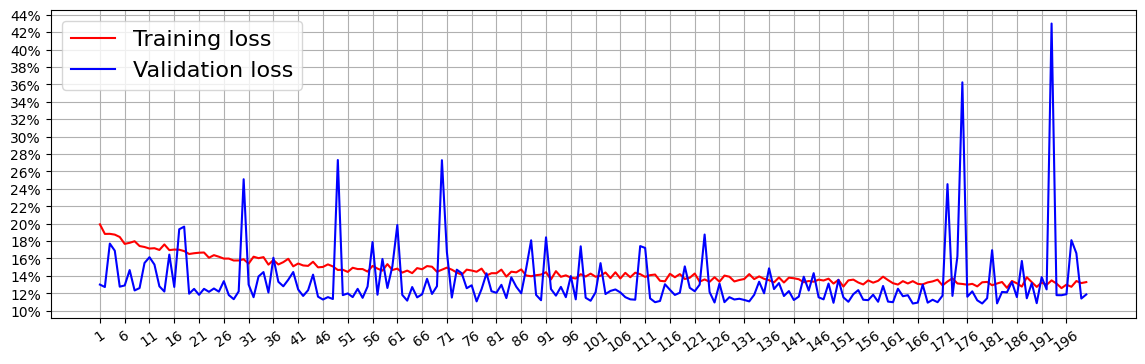

In [34]:
# loss chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
x = np.arange(0, epochs, 5)
plt.xticks(ticks=x, labels=x+1, rotation=35)
y = np.arange(0, 1.05, .02)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['loss'], 'r', label='Training loss')
plt.plot(train_history.history['val_loss'], 'b', label='Validation loss')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()